In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns
from sklearn.model_selection import GridSearchCV,KFold
import warnings

# Désactiver tous les avertissements
warnings.filterwarnings('ignore')

# Ou désactiver uniquement les avertissements de type FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)


In [2]:
df = pd.read_csv('dataset.csv')
df['NewExist'] = df['NewExist'].fillna(0)

In [16]:


features_of_interest = [
    'State','cat_activites', 'UrbanRural','LowDoc','bank_loan_float','SBA_loan_float','FranchiseCode','BankState','RevLineCr','Term','ApprovalFY','crisis',
    'MIS_Status',
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term'
    
]


ordinal_column = [
    'LowDoc'
]

categorical_column = [
    'State','cat_activites','FranchiseCode','BankState','RevLineCr',
]


target_name = "MIS_Status"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('MIS_Status', axis=1)
X_test = X_test.drop('MIS_Status', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [17]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),
    ],
    remainder="passthrough",
)

In [ ]:


clf = make_pipeline(preprocessor,lgb.LGBMClassifier()) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans
clf.fit(X_train, y_train_encoded)

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.861927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 674
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'cat_activites',
                                                   'FranchiseCode', 'BankState',
                                                   'RevLineCr']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc']),
                                                 ('numeric', StandardScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [13]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', clf.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AUC-ROC score: 0.97785199130628


c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


accuracy 0.9478407865031084
rappel 0.8154226333797998
f1_score 0.845865650059156
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



In [11]:
#Dataframe pour les features of importances

df_rf = pd.DataFrame(clf[-1].feature_importances_,clf[0].get_feature_names_out())
df_rf=df_rf.transpose()
df_rf.columns

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [11]:
# Création des sommes pour les features importances pour chaque variable catégorielle


liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)
    


NameError: name 'df_rf' is not defined

In [ ]:
# Création des sommes pour les features importances pour chaque variables


liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)

['sum_State', 'sum_cat_activites', 'sum_UrbanRural', 'sum_LowDoc', 'sum_bank_loan_float', 'sum_SBA_loan_float', 'sum_FranchiseCode', 'sum_BankState', 'sum_RevLineCr', 'sum_Term', 'sum_ApprovalFY', 'sum_crisis', 'sum_MIS_Status']


In [ ]:
df_rf_graphique = df_rf[liste_sum]

In [ ]:
df_rf_graphique


,sum_State,sum_cat_activites,sum_UrbanRural,sum_LowDoc,sum_bank_loan_float,sum_SBA_loan_float,sum_FranchiseCode,sum_BankState,sum_RevLineCr,sum_Term,sum_ApprovalFY,sum_MIS_Status
0,5656,396,78,78,312,495,176,1936,812,3852,1083,0


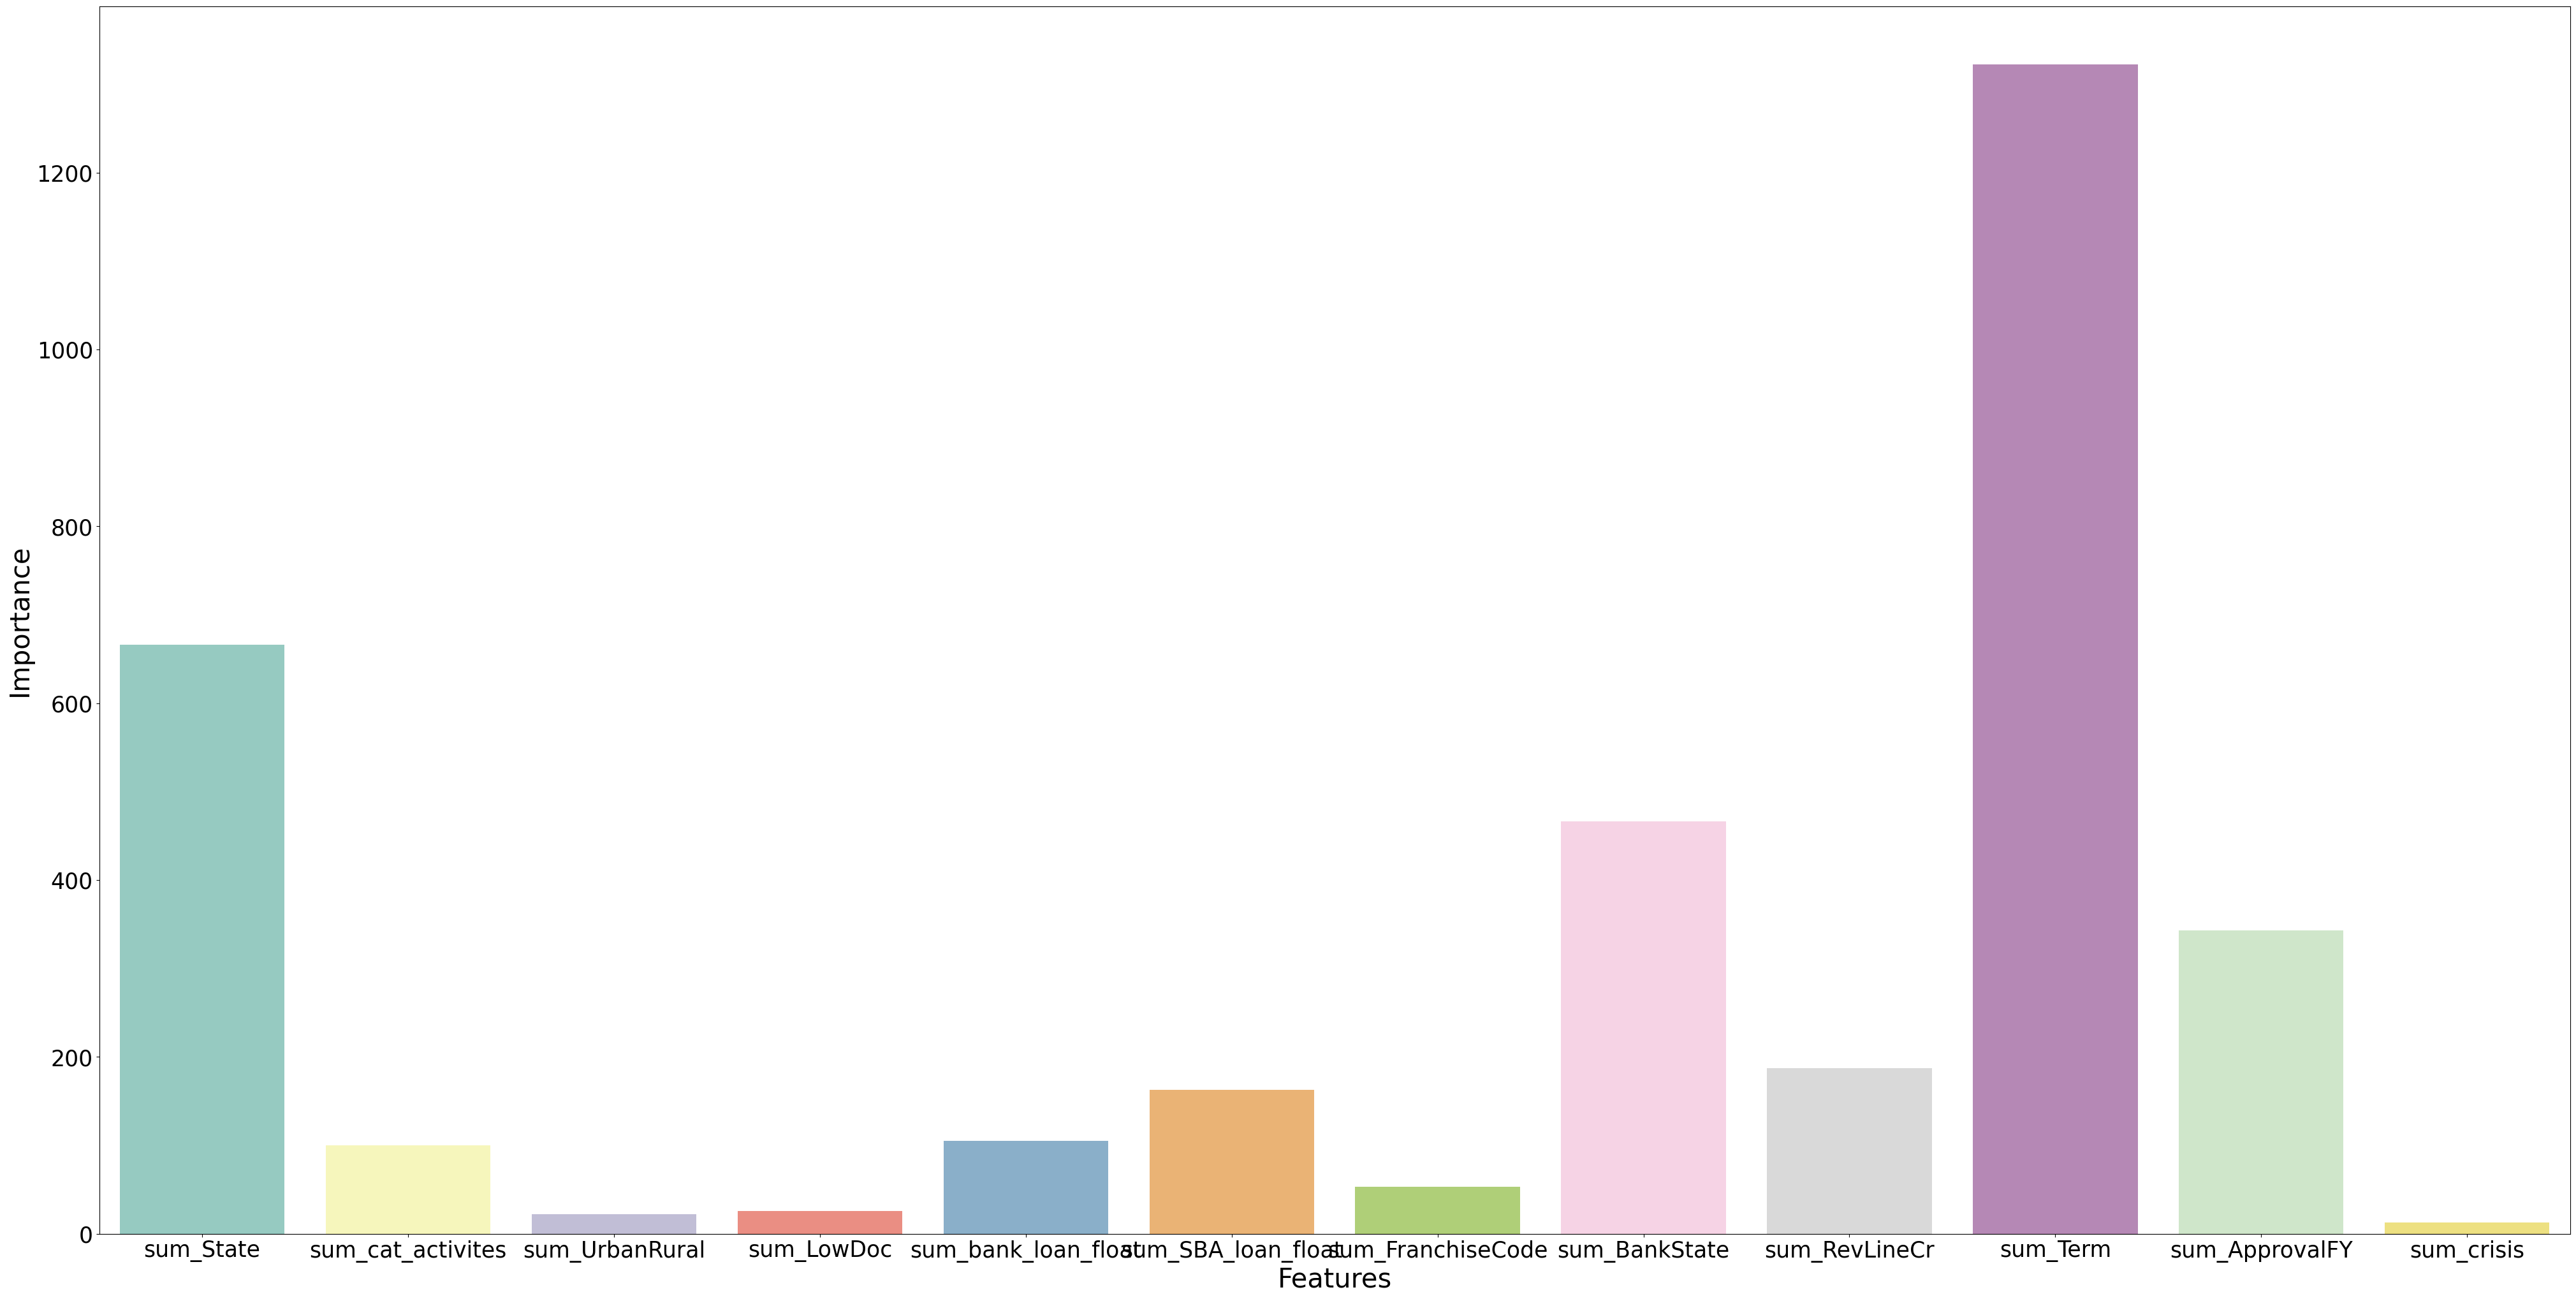

In [ ]:


plt.figure(figsize=(50, 25))
sns.barplot(data=df_rf_graphique.drop('sum_MIS_Status', axis = 1), palette="Set3")

# Augmenter la taille des labels des axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Augmenter la taille des ticks des axes
plt.tick_params(axis='both', labelsize=25)
plt.show()

In [ ]:
y_pred = clf.predict(X_test)
y_pred

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([1, 0, 1, ..., 1, 1, 1], shape=(89917,))

In [20]:
# import pickle
# pickle.dump(clf,open('clf_lgbm.pkl','wb'))
X_train

,State,cat_activites,UrbanRural,LowDoc,bank_loan_float,SBA_loan_float,FranchiseCode,BankState,RevLineCr,Term,ApprovalFY,crisis
769904,IL,45,0,Y,100000.0,90000.0,36560,IL,NaN,60,1995,0
653567,DC,56,0,N,5000.0,4250.0,1,CA,0,1,2003,0
426296,CA,23,1,N,400000.0,300000.0,1,CA,N,120,2001,1
330866,NY,54,1,N,10000.0,5000.0,0,NY,Y,36,2009,0
745739,CA,31,0,N,300000.0,210000.0,1,CA,N,84,1995,0
...,...,...,...,...,...,...,...,...,...,...,...,...
827911,OH,42,2,N,75000.0,37500.0,1,OH,Y,84,2005,0
248832,NY,44,1,N,70000.0,35000.0,0,NY,Y,8,2008,1
730785,IN,54,0,Y,50000.0,45000.0,1,IN,N,84,1994,0
480600,IN,44,0,N,145000.0,145000.0,1,IN,N,240,1992,0


In [ ]:
np.random.seed(1)

train = X_train
test = X_test
# Si y_train_encoded et y_test_encoded sont des numpy.ndarray, les convertir en pandas.Series
y_train_encoded_series = pd.Series(y_train_encoded)
y_test_encoded_series = pd.Series(y_test_encoded)

y = y_train_encoded
print(train.shape, test.shape, y.shape)



gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=train, y=y)

param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=categorical_column)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
lgb_model = gsearch.fit(X=train, y=y)

print(lgb_model.best_params_, lgb_model.best_score_)

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [35]:
train = X_train
test = X_test
# Si y_train_encoded et y_test_encoded sont des numpy.ndarray, les convertir en pandas.Series
y_train_encoded_series = pd.Series(y_train_encoded)
y_test_encoded_series = pd.Series(y_test_encoded)

y = y_train_encoded
print(train.shape, test.shape, y.shape)


preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),
    ],
    remainder="passthrough",
)


# Définir le modèle LGBMClassifier avec un pipeline
lgb_estimator = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    n_estimators=2000,
    learning_rate=0.01,
    metric='auc'
)

# Créer un pipeline qui applique le préprocesseur et entraîne le modèle
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', lgb_estimator)])


# Utilisation de KFold pour la validation croisée
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=train, y=y)


# Définir la grille de paramètres à tester dans GridSearchCV
param_grid = {
    'classifier__num_leaves': [31, 127],
    'classifier__reg_alpha': [0.1, 0.5],
    'classifier__min_data_in_leaf': [30, 50, 100, 300, 400],
    'classifier__lambda_l1': [0, 1, 1.5],
    'classifier__lambda_l2': [0, 1]
}

# Effectuer la recherche par grille
gsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=gkf)

# Entraîner le modèle avec la recherche par grille
lgb_model = gsearch.fit(X=train, y=y)

# Afficher les meilleurs paramètres et le meilleur score
print(lgb_model.best_params_, lgb_model.best_score_)

(809247, 12) (89917, 12) (809247,)
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 533861, number of negative: 113536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.361897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

KeyboardInterrupt: 